In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt


In [2]:
data_weather_encoded = pd.read_csv('data_weather_encoded.csv')

In [3]:
def create_lagged_features(df, window, target_column):
    lagged_df = df.copy()
    original_columns = df.columns.tolist()  # Get a list of all original columns

    # Create lagged features
    for i in range(1, window + 1):
        shifted_df = df.shift(i)
        shifted_df.columns = [f"{column}_lag{i}" for column in shifted_df.columns]
        lagged_df = pd.concat((lagged_df, shifted_df), axis=1)
    
    # Drop all current-day columns including the target column
    lagged_df.drop(columns=original_columns, inplace=True, errors='ignore')
    
    # Drop the first 'window' rows
    lagged_df = lagged_df.iloc[window:]
    return lagged_df




window = 20  
target_column = "mean_temp"  
data_weather_encoded_lagged = create_lagged_features(data_weather_encoded, window, target_column)
y = data_weather_encoded[target_column].iloc[window:]  
X = data_weather_encoded_lagged
# 拆分训练和测试集，按时间顺序
split_index = int(0.8 * len(X))
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


#### 贝叶斯超参数优化

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from bayes_opt import BayesianOptimization, UtilityFunction
import numpy as np

# Define a function for evaluating the model
def evaluate_model(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf, max_features=max_features,n_jobs=10)

    kf = KFold(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")

    return np.mean(scores)

#Define the range of hyperparameters
params = {
    "n_estimators": (100, 1000),
    "max_depth": (1, 50),
    "min_samples_split": (2, 20),
    "min_samples_leaf": (1, 20),
    "max_features": (0.1, 1)
}

# Initialize the Bayesian optimization object
bo = BayesianOptimization(evaluate_model, params)

# Set the getter function for Bayesian optimization
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# Perform a Bayesian optimization procedure
for _ in range(50):
    next_point_to_probe = bo.suggest(utility)
    target = evaluate_model(**next_point_to_probe)
    bo.register(params=next_point_to_probe, target=target)

# Output the best parameters
print("Best Parameters: ", bo.max['params'])

# Evaluate on the test set with the best parameters
best_params = bo.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

print("Test Score: ", best_rf.score(X_test.reshape(X_test.shape[0], -1), y_test))


#### 贝叶斯优化最佳参数模型

Training MSE (CV):  0.22486699209084932
Training MAE (CV):  0.3600310082217807
Training R² (CV):  0.9931687283796353
Test MSE (CV):  1.3816555829551018
Test MAE (CV):  0.9069981018490859
Test R² (CV):  0.956866978538098


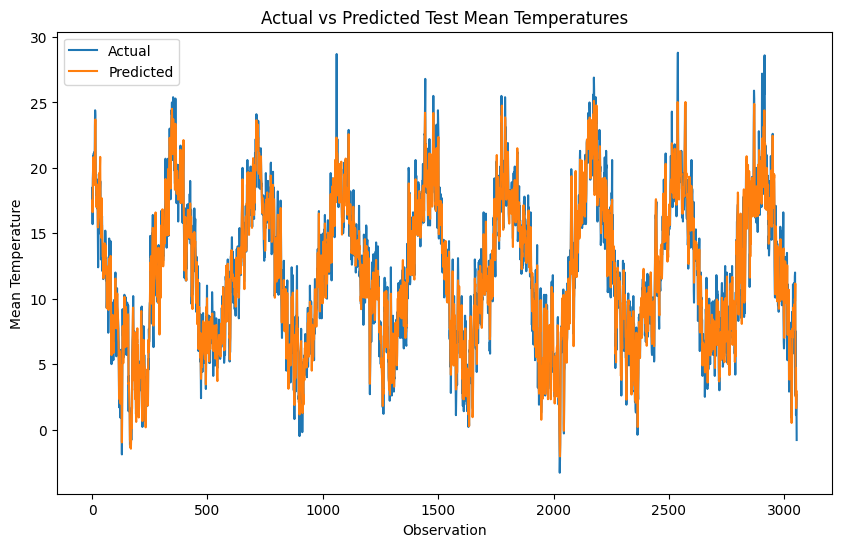

In [7]:

# Reshape training and test set to match model input
X_train_reshaped = X_train.values.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], -1)


from sklearn.model_selection import TimeSeriesSplit

# Assuming you've already reshaped your data and loaded necessary libraries

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Create the model with optimized parameters
model = RandomForestRegressor(n_estimators=int(890), 
                              max_depth=int(28),
                              min_samples_split=int(2.27), 
                              min_samples_leaf=int(3.65), 
                              max_features=0.38,
                              n_jobs=-1)

# Cross-validation
mse_train_list = []
mae_train_list = []
r2_train_list = []

mse_test_list = []
mae_test_list = []
r2_test_list = []

for train_index, test_index in tscv.split(X_train_reshaped):
    X_train_fold, X_test_fold = X_train_reshaped[train_index], X_train_reshaped[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)
    
    y_pred_train_fold = model.predict(X_train_fold)
    mse_train_list.append(mean_squared_error(y_train_fold, y_pred_train_fold))
    mae_train_list.append(mean_absolute_error(y_train_fold, y_pred_train_fold))
    r2_train_list.append(r2_score(y_train_fold, y_pred_train_fold))
    
    y_pred_test_fold = model.predict(X_test_fold)
    mse_test_list.append(mean_squared_error(y_test_fold, y_pred_test_fold))
    mae_test_list.append(mean_absolute_error(y_test_fold, y_pred_test_fold))
    r2_test_list.append(r2_score(y_test_fold, y_pred_test_fold))

print("Training MSE (CV): ", np.mean(mse_train_list))
print("Training MAE (CV): ", np.mean(mae_train_list))
print("Training R² (CV): ", np.mean(r2_train_list))

print("Test MSE (CV): ", np.mean(mse_test_list))
print("Test MAE (CV): ", np.mean(mae_test_list))
print("Test R² (CV): ", np.mean(r2_test_list))

# Training the model on the complete training set
model.fit(X_train_reshaped, y_train)

# Predictions on the entire test set
y_pred_test = model.predict(X_test_reshaped)

# Visualization
plt.figure(figsize=(10,6))
plt.plot(np.array(y_test), label='Actual')
plt.plot(y_pred_test, label='Predicted')
plt.title('Actual vs Predicted Test Mean Temperatures')
plt.xlabel('Observation')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()


#### 判断预测未来所有三天，所有七天和所有十四天的预测精度

In [16]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the window size and the number of features
window_size = 20
num_features = data_weather_encoded.shape[1] - 1 
# Define the periods for forecasting
periods = [1, 3, 7, 14]

# Initialize a dictionary to store the models
models = {}

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=False)

# Loop through each period
for period in periods:
    # Initialize the lists for features and targets
    features, targets = [], []

    # Extract features (weather conditions) and targets (mean temperatures)
    for i in range(window_size, len(data_weather_encoded) - period):
        features.append(data_weather_encoded.iloc[i-window_size:i, data_weather_encoded.columns != 'mean_temp'].values)
        targets.append(data_weather_encoded.iloc[i:i+period, data_weather_encoded.columns == 'mean_temp'].values.ravel())

    # Convert the lists into arrays
    features = np.array(features).reshape(len(features), -1)
    targets = np.array(targets)

    mse_scores, mae_scores, r2_scores = [], [], []
    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = targets[train_index], targets[test_index]

        # Train a RandomForestRegressor model
        model = RandomForestRegressor(n_estimators=int(890), 
                                      max_depth=int(28),
                                      min_samples_split=int(2.27), 
                                      min_samples_leaf=int(3.65), 
                                      max_features=0.38,
                                      n_jobs=-1)
        model.fit(X_train, y_train)

        # Predict on the test set
        y_test_pred = model.predict(X_test)

        # Evaluate the model
        mse_scores.append(mean_squared_error(y_test, y_test_pred))
        mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        r2_scores.append(r2_score(y_test, y_test_pred))

    print(f"Period: {period} days, CV MSE: {np.mean(mse_scores)}, CV MAE: {np.mean(mae_scores)}, CV R^2: {np.mean(r2_scores)}")

    # Save the model to the dictionary (trained on full dataset for the purpose of future predictions)
    model.fit(features, targets)
    models[period] = model



D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

Period: 1 days, CV MSE: 1.2973716345666093, CV MAE: 0.8796609416822931, CV R^2: 0.9598019621817123


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Period: 3 days, CV MSE: 3.513009642227126, CV MAE: 1.4390145509386052, CV R^2: 0.8910102826297793
Period: 7 days, CV MSE: 5.910704632843908, CV MAE: 1.8954880494935509, CV R^2: 0.8165157402401727
Period: 14 days, CV MSE: 7.298757793522695, CV MAE: 2.13481918572977, CV R^2: 0.7732796813251614


#### 实施预测用于对接Dash

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
model = RandomForestRegressor(n_estimators=int(890), 
                              max_depth=int(28),
                              min_samples_split=int(2.27), 
                              min_samples_leaf=int(3.65), 
                              max_features=0.38,
                              n_jobs=-1)
model.fit(X,y)

RandomForestRegressor(max_depth=28, max_features=0.38, min_samples_leaf=3,
                      n_estimators=890, n_jobs=-1)

In [5]:
def predict_future(df, model, window, days_ahead,scaler):
    future_predictions = []
    df_copy = df.copy()
    for _ in range(days_ahead):
        # Create lag data
        lagged_data = create_lagged_features(df_copy, window, target_column)
        
        # predict a value in the future using the last window of data
        last_window = lagged_data.iloc[-1].values.reshape(1, -1)
        last_window_scaled = scaler.transform(last_window)
        next_value = model.predict(last_window_scaled)
        future_predictions.append(next_value[0])
        
        # Update df_copy, add predicted values, and prepare for the next prediction
        next_row = df_copy.iloc[-1].copy()
        next_row[target_column] = next_value
        df_copy = pd.concat([df_copy, pd.DataFrame([next_row])], ignore_index=True)
    
    return future_predictions
# Predict future dates
days_to_predict = [1, 3, 7, 14]
for days in days_to_predict:
    predictions1 = predict_future(data_weather_encoded, model, window, days,scaler)
    print(f"Predictions for the next {days} days: {predictions1}")

D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 1 days: [1.2845402737088134]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 3 days: [1.284540273708813, -0.08943315501602021, -0.1587279784821919]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 7 days: [1.284540273708813, -0.08943315501602025, -0.15872797848219186, -0.575131768512386, -0.6382697714270749, -0.6393304788220513, -0.6384727304530675]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 14 days: [1.284540273708813, -0.08943315501602024, -0.15872797848219192, -0.575131768512386, -0.6382697714270749, -0.6393304788220513, -0.6384727304530675, -0.7148949466575877, -0.6598542412643543, -0.6475506883877675, -0.6764330497841735, -0.6917089433662474, -0.7334166791385898, -0.7484429867884932]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = RandomForestRegressor(n_estimators=int(890), 
                              max_depth=int(28),
                              min_samples_split=int(2.27), 
                              min_samples_leaf=int(3.65), 
                              max_features=0.38,
                              n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=28, max_features=0.38, min_samples_leaf=3,
                      n_estimators=890, n_jobs=-1)

In [34]:

def predict_future(df, model, window, days_ahead,scaler):
    future_predictions = []
    df_copy = df.copy()
    for _ in range(days_ahead):
        # 创建滞后数据
        lagged_data = create_lagged_features(df_copy, window, target_column)
        
        # 使用最后的窗口数据预测未来的一个值
        last_window = lagged_data.iloc[-1].values.reshape(1, -1)
        last_window_scaled = scaler.transform(last_window)
        next_value = model.predict(last_window_scaled)
        future_predictions.append(next_value[0])
        
        # 更新df_copy，添加预测值，为下一次预测做准备
        next_row = df_copy.iloc[-1].copy()
        next_row[target_column] = next_value
        df_copy = pd.concat([df_copy, pd.DataFrame([next_row])], ignore_index=True)
    
    return future_predictions
# 预测未来的日期
days_to_predict = [1, 3, 7, 14]
for days in days_to_predict:
    predictions = predict_future(data_weather_encoded, model, window, days,scaler)
    print(f"Predictions for the next {days} days: {predictions}")


import pickle

# 将预测的结果保存到一个pickle文件中
with open('random_forecast_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 1 days: [2.9200998580071653]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions for the next 3 days: [2.9200998580071653, -0.20947748817973535, 0.050321238062811094]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 7 days: [2.9200998580071653, -0.20947748817973524, 0.050321238062811094, -0.6246395196563733, -0.7023196697185473, -0.6797993529566576, -0.662608293080203]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py

Predictions for the next 14 days: [2.9200998580071658, -0.20947748817973544, 0.05032123806281108, -0.6246395196563733, -0.7023196697185475, -0.6797993529566574, -0.6626082930802029, -0.6829175908361304, -0.6431702772882538, -0.5946925296925294, -0.6035384325412417, -0.7010727069434922, -0.6726594890752181, -0.6425649815228456]


In [ ]:
Predictions for the next 14 days: [1.284540273708813, -0.08943315501602024, -0.15872797848219192, -0.575131768512386, -0.6382697714270749, -0.6393304788220513, -0.6384727304530675, -0.7148949466575877, -0.6598542412643543, -0.6475506883877675, -0.6764330497841735, -0.6917089433662474, -0.7334166791385898, -0.7484429867884932]

#### model.feature_importances

In [24]:
# 假设 model.feature_importances_ 已经从模型中获取
feature_importances = model.feature_importances_

# 定义窗口化特性
windowed_features = [f"{feature}_{i}" for i in range(window_size) for feature in data_weather_encoded.drop('mean_temp', axis=1).columns]

# 创建一个字典存储总的特性重要性
original_features = data_weather_encoded.drop('mean_temp', axis=1).columns
aggregated_importances = {col: 0 for col in original_features}

# 根据原始特性添加重要性
for i in range(len(windowed_features)):
    feature = windowed_features[i]
    original_feature = "_".join(feature.split('_')[:-1])  # 正确提取原始特性名
    aggregated_importances[original_feature] += feature_importances[i]

# 按重要性对特性排序
sorted_importances = sorted(aggregated_importances.items(), key=lambda x: x[1], reverse=True)

# 打印特性重要性
print("\nFeature Importance:")
for feature, importance in sorted_importances:
    print(f'{feature}: {importance}')



Feature Importance:
max_temp: 0.6639486313933044
day: 0.07276296329766725
quarter_Q2: 0.04607388181029197
quarter_Q1: 0.042329870631039275
min_temp: 0.03558467196068523
quarter_Q3: 0.03370932879509662
global_radiation: 0.025352288620407545
quarter_Q4: 0.02366911444736621
pressure: 0.016526598154264816
year: 0.01603182568253296
sunshine: 0.008804810317024141
precipitation: 0.005784223223218393
cloud_cover: 0.0054872963359567754
weekday: 0.00339630321559485
snow_depth: 0.0005381921155495945
